In [11]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# 示例

In [3]:
digits = datasets.load_digits()
data, label = digits.data, digits.target

In [4]:
data.shape

(1797, 64)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.3, random_state=33)

In [8]:
clf = xgb.XGBClassifier(n_jobs=-1)
clf

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)

In [9]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [12]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.9462962962962963

In [13]:
# 特征重要性
from xgboost import plot_importance

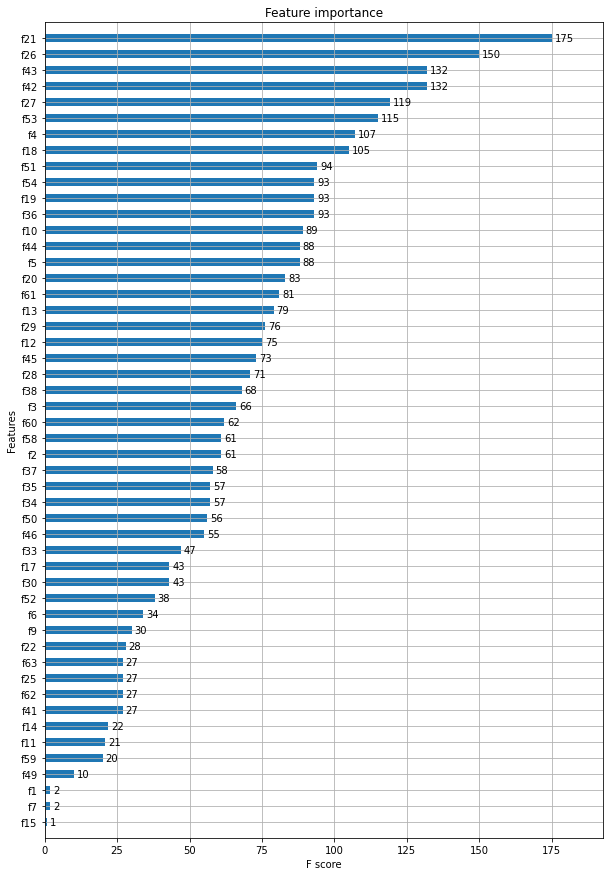

In [14]:
fig, ax = plt.subplots(figsize=(10, 15))
plot_importance(clf, height=.5, max_num_features=64, ax=ax)
plt.show()

# Xgboost模型详解

## 1. 加载解析数据

- libsvm 格式的文本数据；
 
- Numpy 的二维数组；
 
- XGBoost 的二进制的缓存文件。

加载的数据存储在对象 DMatrix 中

In [ ]:
# To load a libsvm text file or a XGBoost binary file into DMatrix

dtrain = xgb.DMatrix('train.svm.txt')
dtest = xgb.DMatrix('test.svm.buffer')

In [ ]:
# To load a CSV file into DMatrix
# label_column specifies the index of the column containing the true label
dtrain = xgb.DMatrix('train.csv?format=csv&label_column=0')
dtest = xgb.DMatrix('test.csv?format=csv&label_column=0')

In [16]:
# To load a NumPy array into DMatrix:
data = np.random.rand(5, 10)
label = np.random.randint(2, size=5)
dtrain = xgb.DMatrix(data, label=label)
dtrain

In [ ]:
# 将scipy.sparse格式的数据转化为Dmatrix格式
csr = scipy.sparse.csr_matrix((dat, (row, col)))
dtrain = xgb.DMatrix(csr)

In [17]:
# To load a Pandas data frame into DMatrix
data = pd.DataFrame(np.arange(12).reshape((4, 3)), columns=[list('abc')])
label = pd.DataFrame(np.random.randint(2, size=4))
dtrain = xgb.DMatrix(data, label=label)

In [ ]:
# 将Dmatrix格式的数据保存成Xgboost的二进制格式，在下次加载时可以提高加载速度，使用方法如下
dtrain = xgb.DMatrix('train.svm.txt')
dtrain.save_binary("train.buffer")

In [ ]:
# 可以使用如下方式处理DMatrix中的缺失值
dtrain = xgb.DMatrix(data, label=label, missing = -999.0)

In [ ]:
# 当需要给样本设置权重时，可以用如下方式
w = np.random.rand(5, 1)
dtrain = xgb.DMatrix(data, label=label, missing=-999.0, weight=w)

## 2. 设置参数

Xgboost使用key-value字典的方式存储参数  

https://xgboost.readthedocs.io/en/latest/parameter.html

https://xgboost.apachecn.org/#/docs/15

- 通用参数（General Parameters）：该参数控制在提升（boosting）过程中使用哪种booster，常用的booster有树模型（tree）和线性模型（linear model）

- Booster参数（Booster Parameters）：这取决于使用哪种booster

- 学习目标参数（Task Parameters）：控制学习的场景，例如在回归问题中会使用不同的参数控制排序

In [ ]:
# xgboost模型 参数例子
params = {
    'booster':'gbtree',
    'objective':'multi:softmax',   # 多分类问题
    'num_class':10,  # 类别数，与multi softmax并用
    'gamma':0.1,    # 用于控制是否后剪枝的参数，越大越保守，一般0.1 0.2的样子
    'max_depth':12,  # 构建树的深度，越大越容易过拟合
    'lambda':2,  # 控制模型复杂度的权重值的L2 正则化项参数，参数越大，模型越不容易过拟合
    'subsample':0.7, # 随机采样训练样本
    'colsample_bytree':3,# 这个参数默认为1，是每个叶子里面h的和至少是多少
    # 对于正负样本不均衡时的0-1分类而言，假设h在0.01附近，min_child_weight为1
    #意味着叶子节点中最少需要包含100个样本。这个参数非常影响结果，
    # 控制叶子节点中二阶导的和的最小值，该参数值越小，越容易过拟合
    'silent':0,  # 设置成1 则没有运行信息输入，最好是设置成0
    'eta':0.007,  # 如同学习率
    'seed':1000,
    'nthread':7,  #CPU线程数
    #'eval_metric':'auc'
}

###  通用参数

- booster [default=gbtree] 

    + 有两种模型可以选择gbtree和gblinear。gbtree使用基于树的模型进行提升计算，gblinear使用线性模型进行提升计算。缺省值为gbtree

- silent [default=0] 

    + 取0时表示打印出运行时信息，取1时表示以缄默方式运行，不打印运行时的信息。缺省值为0
    + 建议取0，过程中的输出数据有助于理解模型以及调参。另外实际上我设置其为1也通常无法缄默运行。

- nthread [default to maximum number of threads available if not set] 
    
    + XGBoost运行时的线程数。缺省值是当前系统可以获得的最大线程数
    + 如果你希望以最大速度运行，建议不设置这个参数，模型将自动获得最大线程

- num_pbuffer [set automatically by xgboost, no need to be set by user] 

    + size of prediction buffer, normally set to number of training instances. The buffers are used to save the prediction results of last boosting step.
- num_feature [set automatically by xgboost, no need to be set by user] 

    + boosting过程中用到的特征维数，设置为特征个数。XGBoost会自动设置，不需要手工设置

### tree booster参数

- eta [default=0.3]  
    + 为了防止过拟合，更新过程中用到的收缩步长。在每次提升计算之后，算法会直接获得新特征的权重。 eta通过缩减特征的权重使提升计算过程更加保守。缺省值为0.3
    + 取值范围为：[0,1]
    
    + 通常最后设置eta为0.01~0.2
- gamma [default=0] 
    
    + minimum loss reduction required to make a further partition on a leaf node of the tree. the larger, the more conservative the algorithm will be.
    
    + range: [0,∞]
    
    + 模型在默认情况下，对于一个节点的划分只有在其loss function 得到结果大于0的情况下才进行，而gamma 给定了所需的最低loss function的值
    
    + gamma值使得算法更conservation，且其值依赖于loss function ，在模型中应该进行调参。

- max_depth [default=6] 
    + 树的最大深度。缺省值为6
    + 取值范围为：[1,∞]
    + 指树的最大深度
    + 树的深度越大，则对数据的拟合程度越高（过拟合程度也越高）。即该参数也是控制过拟合
    + 建议通过交叉验证（xgb.cv ) 进行调参
    + 通常取值：3-10
- min_child_weight [default=1] 
    + 孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束。在现行回归模型中，这个参数是指建立每个模型所需要的最小样本数。该成熟越大算法越conservative。即调大这个参数能够控制过拟合。
    + 取值范围为: [0,∞]
- max_delta_step [default=0] 
    + Maximum delta step we allow each tree’s weight estimation to be. If the value is set to 0, it means there is no constraint. If it is set to a positive value, it can help making the update step more conservative. Usually this parameter is not needed, but it might help in logistic regression when class is extremely imbalanced. Set it to value of 1-10 might help control the update
    + 取值范围为：[0,∞]
    + 如果取值为0，那么意味着无限制。如果取为正数，则其使得xgboost更新过程更加保守。
    + 通常不需要设置这个值，但在使用logistics 回归时，若类别极度不平衡，则调整该参数可能有效果
- subsample [default=1] 
    + 用于训练模型的子样本占整个样本集合的比例。如果设置为0.5则意味着XGBoost将随机的从整个样本集合中抽取出50%的子样本建立树模型，这能够防止过拟合。
    + 取值范围为：(0,1]
- colsample_bytree [default=1] 
    + 在建立树时对特征随机采样的比例。缺省值为1
    + 取值范围：(0,1]
- colsample_bylevel[default=1]
    + 决定每次节点划分时子样例的比例
    + 通常不使用，因为subsample和colsample_bytree已经可以起到相同的作用了
- scale_pos_weight[default=0]
    + A value greater than 0 can be used in case of high class imbalance as it helps in faster convergence.
    + 大于0的取值可以处理类别不平衡的情况。帮助模型更快收敛

### Linear Booster参数

- lambda [default=0] 
    + L2 正则的惩罚系数
    + 用于处理XGBoost的正则化部分。通常不使用，但可以用来降低过拟合
- alpha [default=0] 
    + L1 正则的惩罚系数
    + 当数据维度极高时可以使用，使得算法运行更快。
- lambda_bias 
    + 在偏置上的L2正则。缺省值为0（在L1上没有偏置项的正则，因为L1时偏置不重要）

### 学习目标参数

这个参数是来控制理想的优化目标和每一步结果的度量方法。
- objective [ default=reg:linear ] 
    + 定义学习任务及相应的学习目标，可选的目标函数如下：
    + “reg:linear” –线性回归。
    + “reg:logistic” –逻辑回归。
    + “binary:logistic” –二分类的逻辑回归问题，输出为概率。
    + “binary:logitraw” –二分类的逻辑回归问题，输出的结果为wTx。
    + “count:poisson” –计数问题的poisson回归，输出结果为poisson分布。
    + 在poisson回归中，max_delta_step的缺省值为0.7。(used to safeguard optimization)
    + “multi:softmax” –让XGBoost采用softmax目标函数处理多分类问题，同时需要设置参数num_class（类别个数）
    + “multi:softprob” –和softmax一样，但是输出的是ndata * nclass的向量，可以将该向量reshape成ndata行nclass列的矩阵。每行数据表示样本所属于每个类别的概率。
    + “rank:pairwise” –set XGBoost to do ranking task by minimizing the pairwise loss
- base_score [ default=0.5 ] 
    + the initial prediction score of all instances, global bias
- eval_metric [ default according to objective ] 
    + 校验数据所需要的评价指标，不同的目标函数将会有缺省的评价指标（rmse for regression, and error for classification, mean average precision for ranking）
    + 用户可以添加多种评价指标，对于Python用户要以list传递参数对给程序，而不是map参数list参数不会覆盖’eval_metric’
    + The choices are listed below:
    + “rmse”: root mean square error
    + “logloss”: negative log-likelihood
    + “error”: Binary classification error rate. It is calculated as #(wrong cases)/#(all cases). For the predictions, the evaluation will regard the instances with prediction value larger than 0.5 as positive instances, and the others as negative instances.
    + “merror”: Multiclass classification error rate. It is calculated as #(wrong cases)/#(all cases).
    + “mlogloss”: Multiclass logloss
    + “auc”: Area under the curve for ranking evaluation.
    + “ndcg”:Normalized Discounted Cumulative Gain
    + “map”:Mean average precision
    + “ndcg@n”,”map@n”: n can be assigned as an integer to cut off the top positions in the lists for evaluation.
    + “ndcg-“,”map-“,”ndcg@n-“,”map@n-“: In XGBoost, NDCG and MAP will evaluate the score of a list without any positive samples as 1. By adding “-” in the evaluation metric XGBoost will evaluate these score as 0 to be consistent under some conditions. training repeatively
- seed [ default=0 ] 
    + 随机数的种子。缺省值为0
    + 可以用于产生可重复的结果（每次取一样的seed即可得到相同的随机划分）

## 3 Xgboost基本方法和默认参数

In [18]:
xgb.train?

Signature:
xgb.train(
    params,
    dtrain,
    num_boost_round=10,
    evals=(),
    obj=None,
    feval=None,
    maximize=False,
    early_stopping_rounds=None,
    evals_result=None,
    verbose_eval=True,
    xgb_model=None,
    callbacks=None,
)
Docstring:
Train a booster with given parameters.

Parameters
----------
params : dict
    Booster params.
dtrain : DMatrix
    Data to be trained.
num_boost_round: int
    Number of boosting iterations.
evals: list of pairs (DMatrix, string)
    List of validation sets for which metrics will evaluated during training.
    Validation metrics will help us track the performance of the model.
obj : function
    Customized objective function.
feval : function
    Customized evaluation function.
maximize : bool
    Whether to maximize feval.
early_stopping_rounds: int
    Activates early stopping. Validation metric needs to improve at least once in
    every **early_stopping_rounds** round(s) to continue training.
    Requires at least one i

- parms：这是一个字典，里面包含着训练中的参数关键字和对应的值，形式是parms = {'booster':'gbtree','eta':0.1}

- dtrain：训练的数据

- num_boost_round：这是指提升迭代的个数

　　evals：这是一个列表，用于对训练过程中进行评估列表中的元素。形式是evals = \[(dtrain,'train'),(dval,'val')\] 或者是 evals =\[(dtrain,'train')\] ，对于第一种情况，它使得我们可以在训练过程中观察验证集的效果。

- obj ：自定义目的函数

- feval：自定义评估函数

- maximize：是否对评估函数进行最大化

- early_stopping_rounds：早起停止次数，假设为100，验证集的误差迭代到一定程度在100次内不能再继续降低，就停止迭代。这要求evals里至少有一个元素，如果有多个，按照最后一个去执行。返回的是最后的迭代次数（不是最好的）。如果early_stopping_rounds存在，则模型会生成三个属性，bst.best_score ,bst.best_iteration和bst.best_ntree_limit

- evals_result：字典，存储在watchlist中的元素的评估结果

- verbose_eval（可以输入布尔型或者数值型）：也要求evals里至少有一个元素，如果为True，则对evals中元素的评估结果会输出在结果中；如果输入数字，假设为5，则每隔5个迭代输出一次。

- learning_rates：每一次提升的学习率的列表

- xgb_model：在训练之前用于加载的xgb_model

In [ ]:
# 训练
num_round = 10
bst = xgb.train(params, dtrain, num_round, evallist)


In [ ]:
# 保存模型
bst.save_model('0001.model')

In [ ]:
# 导出模型和特征映射（Map）
# 导出模型到文件
bst.dump_model('dump.raw.txt')
# 导出模型和特征映射
bst.dump_model('dump.raw.txt','featmap.txt')

In [ ]:
# 加载模型 
bst = xgb.Booster({'nthread': 4})  # init model
bst.load_model('model.bin')  # load data

In [ ]:
# 预测
data = np.random.rand(7, 10)
dtest = xgb.DMatrix(data)
ypred = bst.predict(dtest)

# If early stopping is enabled during training, you can get predictions from the best iteration with bst.best_ntree_limit:
ypred = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)

# Xgboost实战
Xgboost有两大类接口：Xgboost原生接口 和sklearn接口，并且Xgboost能够实现分类回归两种任务

##  1 基于Xgboost原生接口的分类

[21:17:50] WARNING: /workspace/src/learner.cc:480: 
Parameters: { slient } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


acc: 93.33%


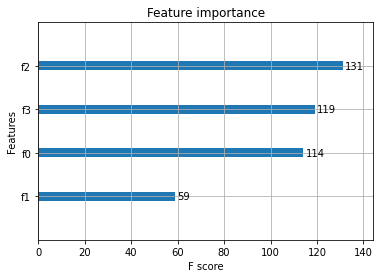

In [22]:
from sklearn.datasets import load_iris
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 记载样本数据集
iris = load_iris()
X,y = iris.data,iris.target
# 数据集分割
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=123457)
# 算法参数
params = {
    'booster': 'gbtree',
    'objective': 'multi:softmax',
    'num_class': 3,
    'gamma': 0.1,
    'max_depth': 6,
    'lambda': 2,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3,
    'slient': 1, 
    'eta': 0.1,
    'seed': 1000,
    'nthread': 4,
}
plst = params.items()

# 生成数据集格式
dtrain = xgb.DMatrix(X_train, y_train)
num_rounds = 500
# 训练
model = xgb.train(params, dtrain, num_rounds)

# 对测试集进行预测
dtest = xgb.DMatrix(X_test)
y_pred = model.predict(dtest)

# 计算准确率
acc = accuracy_score(y_test, y_pred)
print("acc: {:.2%}".format(acc))

# 显示重要特征
plot_importance(model)
plt.show()

## 2，基于Xgboost原生接口的回归

[21:22:47] WARNING: /workspace/src/learner.cc:480: 
Parameters: { slient } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




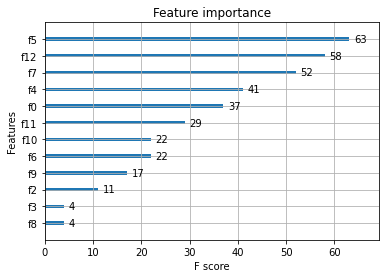

In [23]:
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error

# 加载数据集,此数据集时做回归的
boston = load_boston()
X,y = boston.data,boston.target
 
# Xgboost训练过程
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

params = {
    'booster':'gbtree',
    'objective':'reg:gamma',
    'gamma':0.1,
    'max_depth':5,
    'lambda':3,
    'subsample':0.7,
    'colsample_bytree':0.7,
    'min_child_weight':3,
    'slient':1,
    'eta':0.1,
    'seed':1000,
    'nthread':4,
}
dtrain = xgb.DMatrix(X_train, y_train)
num_rounds = 300
model = xgb.train(params, dtrain, num_rounds)

dtest = xgb.DMatrix(X_test)
ans = model.predict(dtest)

# 显示重要特征
plot_importance(model)
plt.show()

##  3 Xgboost使用sklearn接口的分类（推荐）

In [ ]:
from xgboost.sklearn import XGBClassifier

clf = XGBClassifier(
    verbosity=2,  # The degree of verbosity. Valid values are 0 (silent) - 3 (debug).
    max_depth=6, # 构建树的深度，越大越容易过拟合
    learning_rate=0.3  # 学习率
    objective="multi:softmax",  # 多分类问题，指定学习任务和响应的学习目标
    # num_class = 10,  # 类别数，多分类与multisoftmax并用
    booster='gbtree',
    n_jobs=4,
    gamma=0, # 树的叶子节点上做进一步分区所需的最小损失减少，越大越保守，一般0.1 0.2这样子
    min_child_weight= 1,
    # 这个参数默认为1，是每个叶子里面h的和至少是多少，对正负样本不均衡时的0-1分类而言
    # 假设h在0.01附近，min_child_weight为1 意味着叶子节点中最少需要包含100个样本
    # 这个参数非常影响结果，控制叶子节点中二阶导的和的最小值，该参数值越小，越容易过拟合
    subsample=1, # 随机采样训练样本，训练实例的子采样比
    max_delta_step=0,  # 我们允许每个树的权重估计的最大增量步长，
    colsample_bytree=1, # 生成树时进行的列采样
    reg_lambda=1, #控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合
    # reg_alpha=0, # L1正则项参数
    n_estimators=100,  # 树的个数
    random_state=123,
)

27:31] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[22:27:31] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[22:27:31] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[22:27:31] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[22:27:31] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[22:27:31] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[22:27:31] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[22:27:31] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[22:27:31] INFO: /workspace/src/tree/updater_prune.c

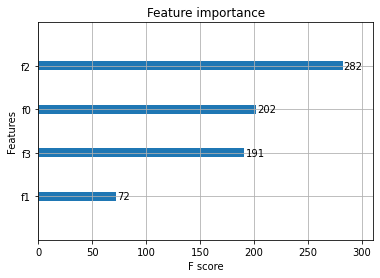

In [33]:
from sklearn.datasets import load_iris
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 加载样本数据集
iris = load_iris()
X,y = iris.data,iris.target
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=12343)
model = xgb.XGBClassifier(
    max_depth=5,
    learning_rate=0.1, 
    n_estimators=160, 
    verbosity=2, 
    objective='multi:softmax')

model.fit(X_train, y_train)
#设置验证集合
# model.fit(X_train, y_train,
#          eval_set=[(X_train, y_train), (X_test, y_test)],
#         #  eval_metric='auc',
#          verbose=True)
#获取验证集合结果
# evals_result = clf.evals_result()

y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("acc: {:.2%}".format(acc))
# print("evals_result: ", evals_result)
# 显示重要特征
plot_importance(model)
plt.show()

## 4，基于Scikit-learn接口的回归

mae: 2.80


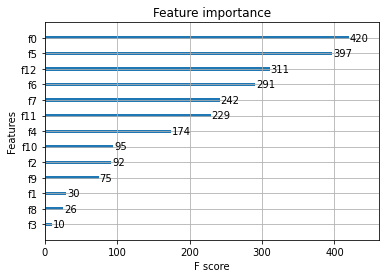

In [28]:
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston
from sklearn.metrics import mean_absolute_error
 
# 导入数据集
boston = load_boston()
X ,y = boston.data,boston.target
 
# Xgboost训练过程
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

model = xgb.XGBRegressor(
    max_depth=5, 
    learning_rate=0.1, 
    n_estimators=160, 
    verbosity=0, 
    objective='reg:gamma')
model.fit(X_train, y_train)
ans = model.predict(X_test)
print("mae: {:.2f}".format(mean_absolute_error(y_test, ans)))

plot_importance(model)
plt.show()

## 官方例子 

### sklearn-examples

In [6]:
import pickle
import xgboost as xgb

import numpy as np
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error, mean_absolute_error
from sklearn.datasets import load_iris, load_digits, load_boston

rng = np.random.RandomState(31337)
print("Zeros and Ones from the Digits dataset: binary classification")
digits = load_digits(n_class=2)
y = digits['target']
X = digits['data']

kf = KFold(n_splits=2, shuffle=True, random_state=rng)
for train_index, test_index in kf.split(X):
    xgb_model = xgb.XGBClassifier().fit(X[train_index], y[train_index])
    predictions = xgb_model.predict(X[test_index])
    actuals = y[test_index]
    print(confusion_matrix(actuals, predictions))

Zeros and Ones from the Digits dataset: binary classification
[[87  0]
 [ 1 92]]
[[91  0]
 [ 2 87]]


In [5]:
print("Iris: multiclass classification")
iris = load_iris()
y = iris['target']
X = iris['data']
kf = KFold(n_splits=2, shuffle=True, random_state=rng)
for train_index, test_index in kf.split(X):
    xgb_model = xgb.XGBClassifier().fit(X[train_index], y[train_index])
    predictions = xgb_model.predict(X[test_index])
    actuals = y[test_index]
    print(confusion_matrix(actuals, predictions))

Iris: multiclass classification
[[19  0  0]
 [ 0 31  3]
 [ 0  1 21]]
[[31  0  0]
 [ 0 16  0]
 [ 0  1 27]]


In [8]:
print("Boston Housing: regression")
boston = load_boston()
y = boston['target']
X = boston['data']
kf = KFold(n_splits=2, shuffle=True, random_state=rng)
for train_idx, test_idx in kf.split(X):
    xgb_model = xgb.XGBRegressor().fit(X[train_idx], y[train_idx])
    predictions = xgb_model.predict(X[test_idx])
    actuals = y[test_idx]
    print("MSE: ", mean_squared_error(actuals, predictions))
    print("MAE: ", mean_absolute_error(actuals, predictions))


Boston Housing: regression
MSE:  18.65979328276533
MAE:  2.5480867725115988
MSE:  10.7981717083327
MAE:  2.3434300946623905


In [9]:
print("Parameter optimization")
y = boston['target']
X = boston['data']
xgb_model = xgb.XGBRFRegressor()
clf = GridSearchCV(
    xgb_model,
    {'max_depth':[2, 4, 6],
     'n_estimators': [50, 100, 200]}, verbose=1
)
clf.fit(X, y)
print(clf.best_score_)
print(clf.best_params_)

Parameter optimization
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
0.6022341153135775
{'max_depth': 6, 'n_estimators': 200}
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    1.3s finished


In [12]:
# The sklearn API models are picklable
print("Pickling sklearn API models")
pickle.dump(clf, open('best_boston.pkl', 'wb'))
clf2 = pickle.load(open('best_boston.pkl', 'rb'))
print(np.allclose(clf.predict(X), clf2.predict(X)))

Pickling sklearn API models
True


In [13]:
# Early-stopping
X = digits['data']
y = digits['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train, early_stopping_rounds=10, eval_metric='auc', eval_set=[(X_test, y_test)])
eval_results = clf.evals_result()

[0]	validation_0-auc:0.99950
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.99975
[2]	validation_0-auc:0.99975
[3]	validation_0-auc:0.99975
[4]	validation_0-auc:0.99975
[5]	validation_0-auc:0.99975
[6]	validation_0-auc:1.00000
[7]	validation_0-auc:1.00000
[8]	validation_0-auc:1.00000
[9]	validation_0-auc:1.00000
[10]	validation_0-auc:1.00000
[11]	validation_0-auc:1.00000
[12]	validation_0-auc:1.00000
[13]	validation_0-auc:1.00000
[14]	validation_0-auc:1.00000
[15]	validation_0-auc:1.00000
[16]	validation_0-auc:1.00000
Stopping. Best iteration:
[6]	validation_0-auc:1.00000



### sklearn_evals_result

In [16]:
import xgboost as xgb
import numpy as np
from sklearn.datasets import make_hastie_10_2
import matplotlib.pyplot as plt

X, y = make_hastie_10_2(n_samples=2000, random_state=42)

In [24]:
# Map labels from {-1, 1} to {0, 1}
labels, y = np.unique(y, return_inverse=True)
# labels[y]等于y

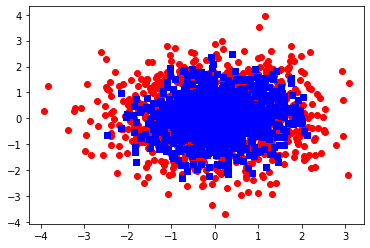

In [30]:
plt.scatter(X[y==1, 0], X[y==1, 1], marker='o', c='red')
plt.scatter(X[y==0, 0], X[y==0, 1], marker='s', c='blue')

In [ ]:
X_train, X_test = X[:1600], X[1600:]
y_train, y_test = y[:1600], y[1600:]

In [31]:
params = {"objective":'binary:logistic', 'n_estimators':2}
clf = xgb.XGBModel(**params)
# clf = xgb.XGBClassifier(**param_dist)
clf.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric='logloss',
        verbose=True)

[0]	validation_0-logloss:0.44743	validation_1-logloss:0.45211
[1]	validation_0-logloss:0.30947	validation_1-logloss:0.31738


XGBModel(base_score=0.5, booster='gbtree', colsample_bylevel=1,
         colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
         interaction_constraints='', learning_rate=0.300000012,
         max_delta_step=0, max_depth=6, min_child_weight=1,
         monotone_constraints='()', n_estimators=2, n_jobs=0,
         num_parallel_tree=1, objective='binary:logistic', random_state=0,
         reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
         tree_method='exact', validate_parameters=1)

In [35]:
evals_result

{'validation_0': {'logloss': [0.447425, 0.309474]},
 'validation_1': {'logloss': [0.45211, 0.31738]}}

In [37]:
# Load evals result by calling the evals_result() function
evals_result = clf.evals_result()
print('Access logloss metric directly from validation_0:')
print(evals_result['validation_0']['logloss'])
print('')
print('Access metrics through a loop:')
for e_name, e_mtrs in evals_result.items():
    print('- {}'.format(e_name))
    for e_mtr_name, e_mtr_vals in e_mtrs.items():
        print('   - {}'.format(e_mtr_name))
        print('      - {}'.format(e_mtr_vals))
print('')
print('Access complete dict:')
print(evals_result)

Access logloss metric directly from validation_0:
[0.447425, 0.309474]

Access metrics through a loop:
- validation_0
   - logloss
      - [0.447425, 0.309474]
- validation_1
   - logloss
      - [0.45211, 0.31738]

Access complete dict:
{'validation_0': {'logloss': [0.447425, 0.309474]}, 'validation_1': {'logloss': [0.45211, 0.31738]}}


### sklearn_parallel

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_boston
import xgboost as xgb

print("Parallel Parameter optimization")
boston = load_boston()

y = boston['target']
X = boston['data']
xgb_model = xgb.XGBRegressor()
clf = GridSearchCV(xgb_model, {'max_depth': [2, 4, 6],
                                'n_estimators': [50, 100, 200]}, verbose=1,
                    n_jobs=2)
clf.fit(X, y)
print(clf.best_score_)
print(clf.best_params_)

Parallel Parameter optimization
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
0.6839859042772509
{'max_depth': 2, 'n_estimators': 100}
[Parallel(n_jobs=2)]: Done  45 out of  45 | elapsed:    1.8s finished
